<a href="https://colab.research.google.com/github/minhtripham9/sarcasm-detection/blob/master/Code/BERT-DS2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## BERT-DS2

### Managing imports

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import joblib
import torch
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import classification_report, confusion_matrix
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout
from torch.utils.data import TensorDataset, DataLoader
from torch.optim import AdamW
from tqdm import tqdm



## Without context

#### Loading dataset 2

In [3]:
# Only read the first 4400 rows and specific columns
cols_to_use = ['label', 'comment', 'parent_comment']

df = pd.read_csv('train-balanced-sarcasm.csv', usecols=cols_to_use, nrows=4400)

# Rename columns
df = df.rename(columns={
    'comment': 'response',
    'parent_comment': 'context'
})

df

,label,response,context
0,1,That's exactly what a country who made up a ho...,China Tells Trump That Climate Change Is No Ho...
1,1,but it still snows,Facts for those who dispute man-made climate c...
2,0,"lol, you can't make this stuff up.","""Suppression of dissent is about as facist as ..."
3,0,He didn't drink the compliance,"The Worst ""Got Talent"" Judges Go on a Power Trip"
4,0,"In the Half Life series, the reason Gordon Fre...",What 'fan theories' have blown your mind with ...
...,...,...,...
4395,1,"Not to be sexist but uhhhh, stupid women have ...","""Not tryna be racist but uhhh"""
4396,0,He's opposed only when they don't pick him.,Wait wait. Please. Let me stop laughing at the...
4397,0,Round Aboot.,Canadian Solution to SimCity's Round-about Pro...
4398,0,That's some pretty impressive camouflage though.,As a hunter i find this super pathetic.


#### Dataset 2 preparation


In [4]:
df['input_text'] = df['response']

# Check the result
print(df[['input_text', 'label']].head())
df

                                          input_text  label
0  That's exactly what a country who made up a ho...      1
1                                 but it still snows      1
2                 lol, you can't make this stuff up.      0
3                     He didn't drink the compliance      0
4  In the Half Life series, the reason Gordon Fre...      0


,label,response,context,input_text
0,1,That's exactly what a country who made up a ho...,China Tells Trump That Climate Change Is No Ho...,That's exactly what a country who made up a ho...
1,1,but it still snows,Facts for those who dispute man-made climate c...,but it still snows
2,0,"lol, you can't make this stuff up.","""Suppression of dissent is about as facist as ...","lol, you can't make this stuff up."
3,0,He didn't drink the compliance,"The Worst ""Got Talent"" Judges Go on a Power Trip",He didn't drink the compliance
4,0,"In the Half Life series, the reason Gordon Fre...",What 'fan theories' have blown your mind with ...,"In the Half Life series, the reason Gordon Fre..."
...,...,...,...,...
4395,1,"Not to be sexist but uhhhh, stupid women have ...","""Not tryna be racist but uhhh""","Not to be sexist but uhhhh, stupid women have ..."
4396,0,He's opposed only when they don't pick him.,Wait wait. Please. Let me stop laughing at the...,He's opposed only when they don't pick him.
4397,0,Round Aboot.,Canadian Solution to SimCity's Round-about Pro...,Round Aboot.
4398,0,That's some pretty impressive camouflage though.,As a hunter i find this super pathetic.,That's some pretty impressive camouflage though.


In [5]:
# Split
X_train, X_test, y_train, y_test = train_test_split(
    df['input_text'], df['label'],
    test_size=0.2, random_state=42, stratify=df['label']
)

train_df = pd.DataFrame({'input_text': X_train, 'label': y_train})
test_df = pd.DataFrame({'input_text': X_test, 'label': y_test})


print("Train and test splits saved!")

Train and test splits saved!


### Transformers based models : RoBERTa

#### Training


In [6]:
X_train_roberta = train_df['input_text'].astype(str).tolist()
y_train_roberta = train_df['label'].tolist()
X_test_roberta = test_df['input_text'].astype(str).tolist()
y_test_roberta = test_df['label'].tolist()

tokenizer = AutoTokenizer.from_pretrained("roberta-base")

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/481 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

In [7]:
X_train_enc_roberta = tokenizer(
    X_train_roberta,
    padding='max_length',
    truncation=True,
    max_length=110,
    return_tensors='pt'
)
X_test_enc_roberta = tokenizer(
    X_test_roberta,
    padding='max_length',
    truncation=True,
    max_length=110,
    return_tensors='pt'
)


In [8]:
# Convert to torch tensors
train_dataset_roberta = TensorDataset(
    X_train_enc_roberta['input_ids'],
    X_train_enc_roberta['attention_mask'],
    torch.tensor(y_train_roberta)
)

test_dataset_roberta = TensorDataset(
    X_test_enc_roberta['input_ids'],
    X_test_enc_roberta['attention_mask'],
    torch.tensor(y_test_roberta)
)


In [9]:
batch_size = 32

train_loader = DataLoader(train_dataset_roberta, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset_roberta, batch_size=batch_size)

In [10]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model = AutoModelForSequenceClassification.from_pretrained("roberta-base", num_labels=2)
model = model.to(device)
optimizer = AdamW(model.parameters(), lr=2e-5)

model.safetensors:   0%|          | 0.00/499M [00:00<?, ?B/s]

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


               precision    recall  f1-score   support

Not Sarcastic       0.57      1.00      0.73       501
    Sarcastic       0.00      0.00      0.00       379

     accuracy                           0.57       880
    macro avg       0.28      0.50      0.36       880
 weighted avg       0.32      0.57      0.41       880



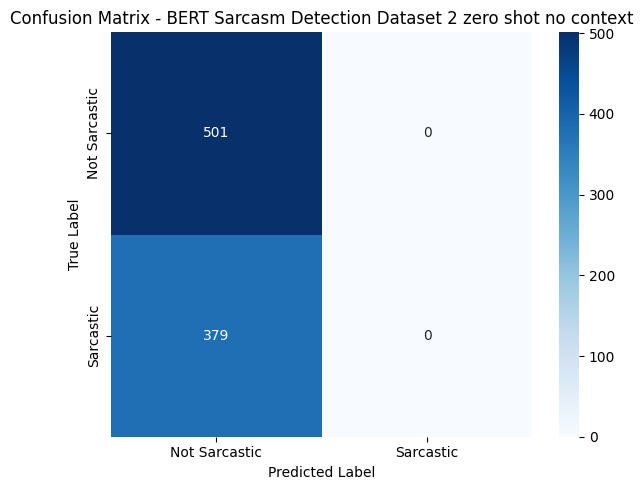

In [11]:
model.eval()
preds_byt5, truths_byt5 = [], []
with torch.no_grad():
    for batch in test_loader:
        b_input_ids, b_attn_mask, b_labels = [x.to(device) for x in batch]
        outputs = model(input_ids=b_input_ids, attention_mask=b_attn_mask)
        logits = outputs.logits
        preds_byt5.extend(torch.argmax(logits, dim=1).cpu().numpy())
        truths_byt5.extend(b_labels.cpu().numpy())

print(classification_report(truths_byt5, preds_byt5, target_names=['Not Sarcastic', 'Sarcastic']))

cm_byt5 = confusion_matrix(truths_byt5, preds_byt5)
labels = ['Not Sarcastic', 'Sarcastic']

plt.figure(figsize=(6, 5))
sns.heatmap(cm_byt5, annot=True, fmt='d', cmap='Blues',
            xticklabels=labels, yticklabels=labels)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix - BERT Sarcasm Detection Dataset 2 zero shot no context')
plt.tight_layout()
plt.show()

#### Training loop

In [ ]:
epochs = 3

for epoch in range(epochs):
    model.train()
    total_loss = 0
    for batch in tqdm(train_loader):
        b_input_ids, b_attn_mask, b_labels = [x.to(device) for x in batch]
        outputs = model(input_ids=b_input_ids, attention_mask=b_attn_mask, labels=b_labels)
        loss = outputs.loss
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    print(f"Epoch {epoch+1}, Loss: {total_loss/len(train_loader):.4f}")


  0%|          | 0/110 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1750: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `RobertaSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)
100%|██████████| 110/110 [00:58<00:00,  1.88it/s]


Epoch 1, Loss: 0.6330


100%|██████████| 110/110 [01:02<00:00,  1.77it/s]


Epoch 2, Loss: 0.5097


100%|██████████| 110/110 [01:02<00:00,  1.76it/s]

Epoch 3, Loss: 0.3694


#### Evaluation

               precision    recall  f1-score   support

Not Sarcastic       0.79      0.60      0.69       501
    Sarcastic       0.60      0.79      0.68       379

     accuracy                           0.69       880
    macro avg       0.70      0.70      0.69       880
 weighted avg       0.71      0.69      0.69       880



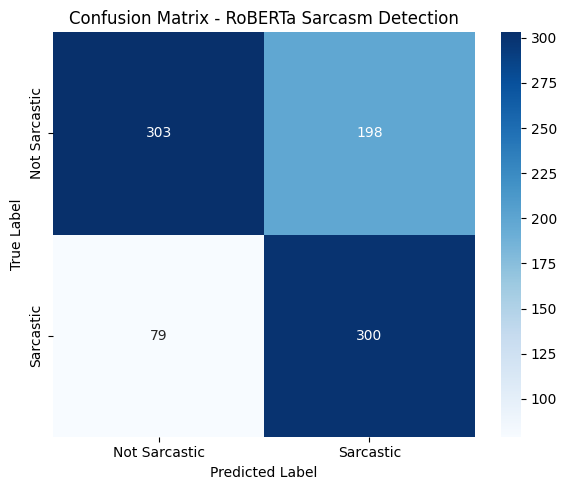

In [ ]:
model.eval()
preds_roberta, truths_roberta = [], []
with torch.no_grad():
    for batch in test_loader:
        b_input_ids, b_attn_mask, b_labels = [x.to(device) for x in batch]
        outputs = model(input_ids=b_input_ids, attention_mask=b_attn_mask)
        logits = outputs.logits
        preds_roberta.extend(torch.argmax(logits, dim=1).cpu().numpy())
        truths_roberta.extend(b_labels.cpu().numpy())

print(classification_report(truths_roberta, preds_roberta, target_names=['Not Sarcastic', 'Sarcastic']))

cm_roberta = confusion_matrix(truths_roberta, preds_roberta)
labels = ['Not Sarcastic', 'Sarcastic']

plt.figure(figsize=(6, 5))
sns.heatmap(cm_roberta, annot=True, fmt='d', cmap='Blues',
            xticklabels=labels, yticklabels=labels)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix - RoBERTa Sarcasm Detection')
plt.tight_layout()
plt.show()


## With context


#### Dataset 2 preparation


In [ ]:
df['input_text'] = df['response'] + ' [SEP] ' + 'Context :' + df['context']

# Check the result
print(df[['input_text', 'label']].head())

                                          input_text  label
0  That's exactly what a country who made up a ho...      1
1  but it still snows [SEP] Context :Facts for th...      1
2  lol, you can't make this stuff up. [SEP] Conte...      0
3  He didn't drink the compliance [SEP] Context :...      0
4  In the Half Life series, the reason Gordon Fre...      0


In [ ]:
# Split
X_train, X_test, y_train, y_test = train_test_split(
    df['input_text'], df['label'],
    test_size=0.2, random_state=42, stratify=df['label']
)

train_df = pd.DataFrame({'input_text': X_train, 'label': y_train})
test_df = pd.DataFrame({'input_text': X_test, 'label': y_test})

print("Train and test splits saved!")

Train and test splits saved!


### Transformers based models : RoBERTa

#### Training


In [ ]:
X_train_roberta = train_df['input_text'].astype(str).tolist()
y_train_roberta = train_df['label'].tolist()
X_test_roberta = test_df['input_text'].astype(str).tolist()
y_test_roberta = test_df['label'].tolist()

tokenizer = AutoTokenizer.from_pretrained("roberta-base")

In [ ]:
X_train_enc_roberta = tokenizer(
    X_train_roberta,
    padding='max_length',
    truncation=True,
    max_length=110,
    return_tensors='pt'
)
X_test_enc_roberta = tokenizer(
    X_test_roberta,
    padding='max_length',
    truncation=True,
    max_length=110,
    return_tensors='pt'
)


In [ ]:
# Convert to torch tensors
train_dataset_roberta = TensorDataset(
    X_train_enc_roberta['input_ids'],
    X_train_enc_roberta['attention_mask'],
    torch.tensor(y_train_roberta)
)

test_dataset_roberta = TensorDataset(
    X_test_enc_roberta['input_ids'],
    X_test_enc_roberta['attention_mask'],
    torch.tensor(y_test_roberta)
)


In [ ]:
batch_size = 32

train_loader = DataLoader(train_dataset_roberta, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset_roberta, batch_size=batch_size)

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model = AutoModelForSequenceClassification.from_pretrained("roberta-base", num_labels=2)
model = model.to(device)
optimizer = AdamW(model.parameters(), lr=2e-5)

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


#### Training loop

In [ ]:
epochs = 3

for epoch in range(epochs):
    model.train()
    total_loss = 0
    for batch in tqdm(train_loader):
        b_input_ids, b_attn_mask, b_labels = [x.to(device) for x in batch]
        outputs = model(input_ids=b_input_ids, attention_mask=b_attn_mask, labels=b_labels)
        loss = outputs.loss
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    print(f"Epoch {epoch+1}, Loss: {total_loss/len(train_loader):.4f}")


  0%|          | 0/110 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1750: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `RobertaSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)
100%|██████████| 110/110 [01:03<00:00,  1.73it/s]


Epoch 1, Loss: 0.6601


100%|██████████| 110/110 [01:03<00:00,  1.73it/s]


Epoch 2, Loss: 0.5465


100%|██████████| 110/110 [01:03<00:00,  1.74it/s]

Epoch 3, Loss: 0.4011


#### Evaluation

               precision    recall  f1-score   support

Not Sarcastic       0.77      0.76      0.76       501
    Sarcastic       0.69      0.69      0.69       379

     accuracy                           0.73       880
    macro avg       0.73      0.73      0.73       880
 weighted avg       0.73      0.73      0.73       880



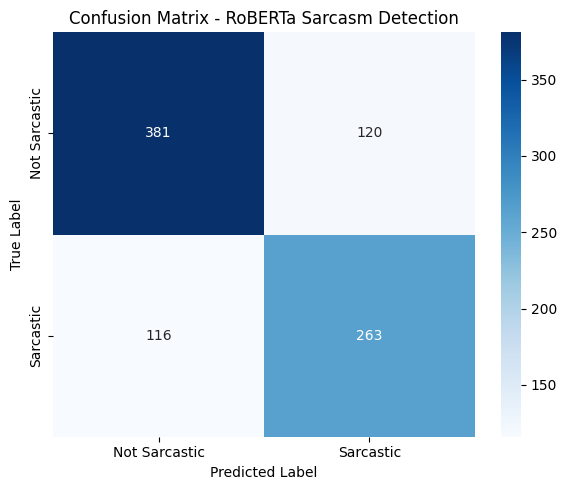

In [ ]:
model.eval()
preds_roberta, truths_roberta = [], []
with torch.no_grad():
    for batch in test_loader:
        b_input_ids, b_attn_mask, b_labels = [x.to(device) for x in batch]
        outputs = model(input_ids=b_input_ids, attention_mask=b_attn_mask)
        logits = outputs.logits
        preds_roberta.extend(torch.argmax(logits, dim=1).cpu().numpy())
        truths_roberta.extend(b_labels.cpu().numpy())

print(classification_report(truths_roberta, preds_roberta, target_names=['Not Sarcastic', 'Sarcastic']))

cm_roberta = confusion_matrix(truths_roberta, preds_roberta)
labels = ['Not Sarcastic', 'Sarcastic']

plt.figure(figsize=(6, 5))
sns.heatmap(cm_roberta, annot=True, fmt='d', cmap='Blues',
            xticklabels=labels, yticklabels=labels)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix - RoBERTa Sarcasm Detection')
plt.tight_layout()
plt.show()
